In [1]:
# Prepare notebook
from matplotlib import pyplot as plt
import re
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit, polyval
%matplotlib inline

In [2]:
# Load data
dfs = dict()
with pd.HDFStore("data.h5") as store:
    for key in store.keys():
        key = key[1:]
        if key == 'meta':
            continue
        dfs[key] = store[key]

    pulse_shape = store.get_storer("meta").attrs['pulse_shape']
    step = store.get_storer("meta").attrs['step']
    time_slice = store.get_storer("meta").attrs['time_slice']
    
pulse_x = np.arange(0, pulse_shape.size * step, step)
waveform_edges = np.arange(0, pulse_shape.size * step + 1, time_slice)
waveform, _ = np.histogram(
    pulse_x, waveform_edges, weights=pulse_shape, density=True
)
waveform_x = np.arange(0, waveform.size * time_slice, time_slice)

# Integration Correction

The integration_correction method in the ctapipe calibration is intended to correct for the missed charge contained in the pulse during charge extraction. It is easy to see how this could occur in the following illustration:

Percent of charge extracted: 47.75%


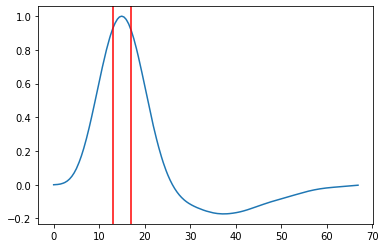

In [3]:
wli = 130
wri = 170
wl = pulse_x[wli]
wr = pulse_x[wri]
window_charge = np.trapz(pulse_shape[wli:wri+1], pulse_x[wli:wri+1])
total_charge = np.trapz(pulse_shape, pulse_x)
plt.plot(pulse_x, pulse_shape)
plt.axvline(wl, color='red')
plt.axvline(wr, color='red')
print(f"Percent of charge extracted: {window_charge/total_charge*100:.2f}%")

This notebook explores the existing integration_correction implementation in ctapipe and considers an improved method.

## Part 0: Perfomance with no integration_correction
The MC data contains the true charge, which we can use to see how closely the extracted charge matches the true charge contained in the waveform pulse. With no integration_correction, we expect there to be a scaling factor missing between the extracted and true charge, which changes according to the extraction window configuration

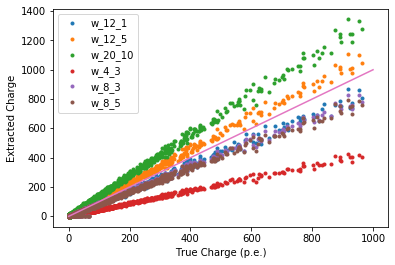

In [4]:
for key, df in dfs.items():
    plt.plot(df['true'], df['extracted'], '.', label=key)
plt.legend(loc='best')
plt.xlabel("True Charge (p.e.)")
plt.ylabel("Extracted Charge")
plt.plot([0, 1000], [0, 1000])

## Part 1: Testing current ctapipe method

In [5]:
def integration_correction(n_chan, pulse_shape, refstep, time_slice, window_width, window_shift):
    correction = np.ones(n_chan)
    for chan in range(n_chan):
        pshape = pulse_shape[chan]
        if pshape.all() is False or time_slice == 0 or refstep == 0:
            continue

        ref_x = np.arange(0, pshape.size * refstep, refstep)
        edges = np.arange(0, pshape.size * refstep + 1, time_slice)

        sampled, sampled_edges = np.histogram(
            ref_x, edges, weights=pshape, density=True
        )
        n_samples = sampled.size
        start = sampled.argmax() - window_shift
        end = start + window_width

        if window_width > n_samples:
            window_width = n_samples
        if start < 0:
            start = 0
        if start + window_width > n_samples:
            start = n_samples - window_width

        integration = np.diff(sampled_edges)[start:end] * sampled[start:end]
        correction[chan] = 1 / np.sum(integration)

    return correction

   window_width  window_shift  scale_uncorrected  scale_ctapipe
0            12             1           0.868761       0.916784
1            12             5           1.130196       0.958571
2            20            10           1.382768       0.971352
3             4             3           0.438063       0.988631
4             8             3           0.845448       0.954970
5             8             5           0.817833       0.985481


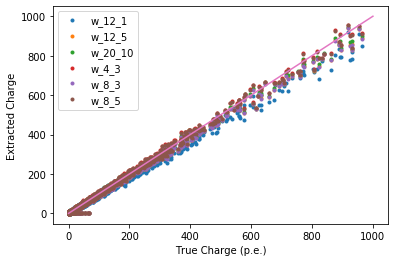

In [6]:
d_list = []

pattern = r"w_(\d+)_(\d+)"
for key, df in dfs.items():
    regex = re.match(pattern, key)
    window_width = int(regex.group(1))
    window_shift = int(regex.group(2))
    correction = integration_correction(1, [pulse_shape], step, time_slice, window_width, window_shift)[0]

    plt.plot(df['true'], df['extracted'] * correction, '.', label=key)
    
    df_reduced = df.loc[df['true'] > 100]
    scale_uncorrected = polyfit(df['true'], df['extracted'], [1])[1]
    scale_ctapipe = polyfit(df['true'], df['extracted'] * correction, [1])[1]

    
    d_list.append({
        'window_width': window_width,
        'window_shift': window_shift,
        'scale_uncorrected': scale_uncorrected,
        'scale_ctapipe': scale_ctapipe
    })
    
table = pd.DataFrame(d_list)
    
plt.legend(loc='best')
plt.plot([0, 1000], [0, 1000])
plt.xlabel("True Charge (p.e.)")
plt.ylabel("Extracted Charge")

print(table)

As one can see, ctapipe's integration_correction quite successfully corrects the charge to reduce the scale factor between the extracted and true charge.

## Part 2: Robustness to different integration windows

The aim of the algorithm is that no matter the location of the integration window on the pulse, the full charge is extracted. We can investigate the robustness of the current algorithm with the reference pulse shape

In [7]:
d_list = []
for start in range(0, waveform.size*2):
    for end in range(0, waveform.size*2):
        width = end - start
        shift = waveform.argmax() - start
        charge = np.sum(np.diff(waveform_edges)[start:end] * waveform[start:end])
        correction = integration_correction(1, [pulse_shape], step, time_slice, width, shift)[0]
        
        result = charge * correction
        d_list.append({
            'start': start,
            'end': end,
            'result': result,
        })
df = pd.DataFrame(d_list)

/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [8]:
df

,start,end,result
0,0,0,NaN
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
...,...,...,...
18491,135,131,NaN
18492,135,132,NaN
18493,135,133,NaN
18494,135,134,NaN


/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


Text(0.5, 0, 'end')

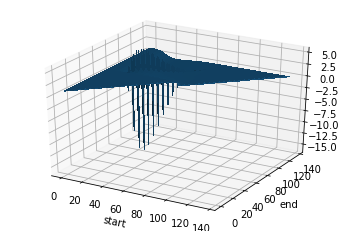

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection='3d')
size = waveform.size*2
X = df['start'].values.reshape((size, size))
Y = df['end'].values.reshape((size, size))
Z = df['result'].values.reshape((size, size))
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel("start")
ax.set_ylabel("end")

Conclusion: current implementation performs as expected when window does not exceed waveform limits, but fails when it does exceed

## Part 3: Improved Algorithm
Can we tidy the current algorithm, to improve its speed and readibility? And also correct the handling when the window is beyond the pulse limits

In [10]:
def integration_correction_new(reference_pulse_shape, reference_pulse_step, waveform_step, window_width, window_shift):
    n_channels = len(reference_pulse_shape)
    correction = np.ones(n_channels, dtype=np.float)
    for ichannel, pulse_shape in enumerate(reference_pulse_shape):
        pulse_max_sample = pulse_shape.size * reference_pulse_step
        pulse_shape_x = np.arange(0, pulse_max_sample, reference_pulse_step)
        sampled_edges = np.arange(0, pulse_max_sample, waveform_step)

        sampled_pulse, _ = np.histogram(
            pulse_shape_x, sampled_edges, weights=pulse_shape, density=True
        )
        n_samples = sampled_pulse.size
        start = sampled_pulse.argmax() - window_shift
        start = start if start >= 0 else 0
        end = start + window_width
        end = end if end < n_samples else n_samples

        integration = sampled_pulse[start:end] * waveform_step
        correction[ichannel] = 1.0 / np.sum(integration)

    return correction

In [11]:
d_list = []
for start in range(0, waveform.size*2):
    for end in range(0, waveform.size*2):
        width = end - start
        shift = waveform.argmax() - start
        charge = np.sum(np.diff(waveform_edges)[start:end] * waveform[start:end])
        correction = integration_correction_new([pulse_shape], step, time_slice, width, shift)[0]
        
        result = charge * correction
        d_list.append({
            'start': start,
            'end': end,
            'result': result,
        })
df = pd.DataFrame(d_list)
print(df)

/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


       start  end  result
0          0    0     NaN
1          0    1     1.0
2          0    2     1.0
3          0    3     1.0
4          0    4     1.0
...      ...  ...     ...
18491    135  131     NaN
18492    135  132     NaN
18493    135  133     NaN
18494    135  134     NaN
18495    135  135     NaN

[18496 rows x 3 columns]


/Users/jason/opt/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


Text(0.5, 0, 'end')

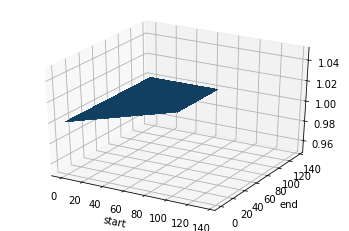

In [12]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection='3d')
size = waveform.size*2
X = df['start'].values.reshape((size, size))
Y = df['end'].values.reshape((size, size))
Z = df['result'].values.reshape((size, size))
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel("start")
ax.set_ylabel("end")